### 1. Polytopic approximation of a polynomial map

We are given the dictionary $D : \text{variables} \to \text{monomials}$, which is applied on a convex polytope $\mathcal{P} := \{ x \in \mathbb{R}^n: Ax \leq b\}$. We are interested in obtaining a polytopic over-approximation of the image of $\mathcal{P}$ under $D$. As an illustration, below we consider the map $D(x_1,x_2) = (x_1^2, x_1 x_2)^\mathrm{T}$, and $\mathcal{P}$ is generated at random.

### 1.1 Polynomial optimization in practice

Suppose we want to solve
$$
f^* := \min \left\{f(x) : x \in \mathcal{P} \right\},
$$
where $\mathcal{P} := \{ x \in \mathbb{R}^n: Ax \leq b\}$. This program can be solved (relaxed) with semidefinite programming. I have been using the package [ncpol2sdpa](http://peterwittek.github.io/ncpol2sdpa/), which is an interface from a polynomial optimization problem to some well-known SDP relaxation solvers (MOSEK and CVXOPT, maybe a couple more). 

In [3]:
from ncpol2sdpa import *
import numpy as np

# Number of variables
n_vars = 2
# Level of relaxation
level = 2

x = generate_variables('x', n_vars, commutative=True)

# Define the objective function
obj = np.array(x[0]*x[1]) # min obj by default

# Inequality constraints
inequalities = [-x[1]**2 + x[1] + 0.5]

# Simple monomial substitutions
substitutions = {x[0]**2 : x[0]}

# Obtain SDP relaxation
sdpRelaxation = SdpRelaxation(x)
sdpRelaxation.get_relaxation(level, objective=obj, inequalities=inequalities,
                             substitutions=substitutions)
sdpRelaxation.solve()
print(sdpRelaxation.primal, sdpRelaxation.dual, sdpRelaxation.status)

(-0.3660254037291204, -0.3660254032953875, 'optimal')


### 1.2 Constructing a random polyhedron

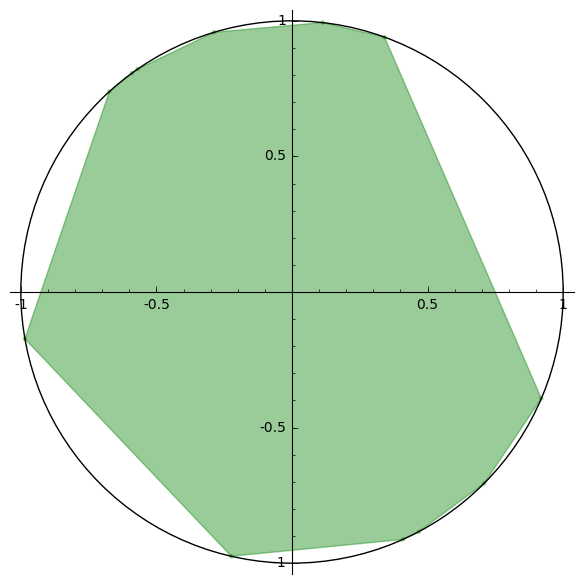

In [4]:
# construct a random polyhedron circumscribed to the unit circle
import random
import numpy as np

k = 12 # number of vertices
angles = [random.uniform(0, 2*pi.n(digits=5)) for i in range(k)]
vertices = list()
for i in range(k):
    v = [exp(I*angles[i]).real(), exp(I*angles[i]).imag()]
    vertices.append(v)
    
P = Polyhedron(vertices = vertices, base_ring=RDF)   
P.plot(alpha=0.4, color='green') + circle([0,0],1,color='black')

### 1.3 Random sampling inside $\mathcal{P}$

To have an idea of the action of $D$, let us consider evaluating it at a bunch of points. This seems easy, right? However the problem of random sampling inside a polyhedron is not trivial. Some methods consist in [triangulations](http://math.stackexchange.com/questions/563129/the-distribution-of-barycentric-coordinates/871220#871220); other methods define a [random walk](http://mathoverflow.net/questions/76255/random-sampling-a-linearly-constrained-region-in-n-dimensions) on the polytope.  However, the easiest (but less performant) trick is to sample uniformly from a surrounding set and reject those which are not inside $\mathcal{P}$. Since $\mathcal{P}$ is inside the unit circle, we have this for free.

*Question*. How do you generate a uniform sample of the unit disk? 

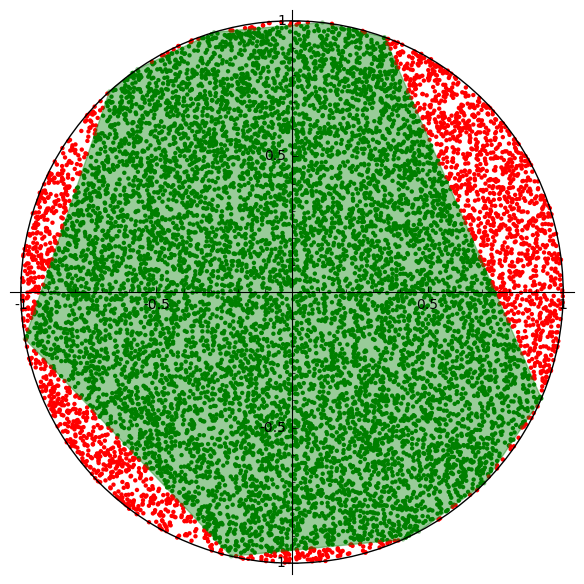

In [5]:
# generate a random sampling inside the polyhedron via rejection sampling
NPOINTS = 1e4
NPOINTS_ACC = 0
fullPointsList = list()
pointsList = list() 
pointsNotAccepted = list() 

while (NPOINTS_ACC < NPOINTS):
    thetai = random.uniform(0,2*pi.n(digits=5))
    ri = random.uniform(0,1)
    randomPoint = sqrt(ri)*cos(thetai), sqrt(ri)*sin(thetai)
    fullPointsList.append(randomPoint)
    if (P.contains(randomPoint)):
        pointsList.append(randomPoint)
        NPOINTS_ACC += 1
    else:
        pointsNotAccepted.append(randomPoint)
        
P.plot(alpha=0.4,color='green') + circle([0,0],1,color='black') + points(pointsList,color='green') + points(pointsNotAccepted,color='red')  

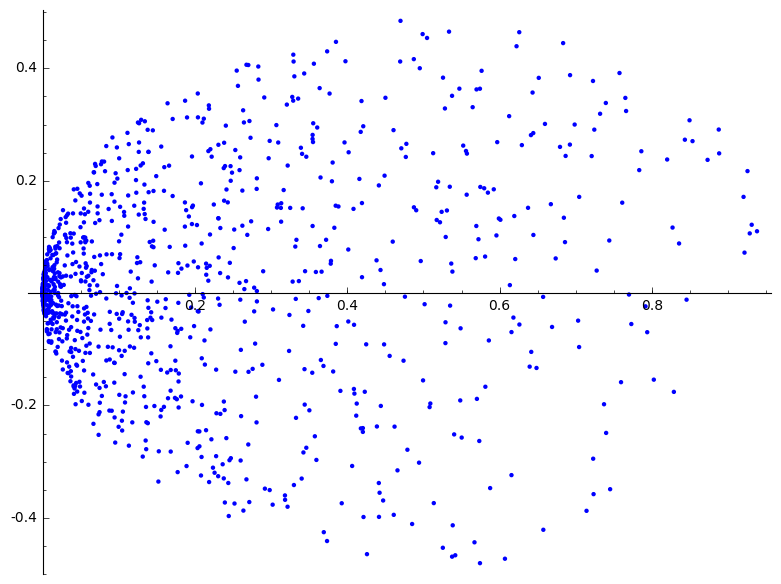

In [3]:
# define a polynomial map

def generate_variable_list(nvars):
    x = list()
    for i in range(nvars):
        x.append(var('x'+str(i)))
    return x
    
def f(x):
    return [ x[0]^2, x[0]*x[1]]

fevaluationPoints = [f(pointsList[i]) for i in range(len(pointsList))]
points(fevaluationPoints)

### 1.4 Box enclosure of the polynomial map

We are ready to find the range of the polynomial map. Then, we see its performance with the points we computed. We should note from the points plot that the set is not convex; this is unfortunate because if it was the case we could get good over-approximations using [support functions](https://en.wikipedia.org/wiki/Support_function). For instance, this is exploited nicely [in this paper](https://infoscience.epfl.ch/record/164244/files/2010%20Polytopic%20Approximation%20of%20Explicit%20Model%20Predictive%20Controllers.pdf?version=1&origin=publication_detail).

In [4]:
def sdp_inequalitiesFromPolyhedron(P,x):
     
    n_vars = len(x)
    inequalities = list()
    PineqList = np.array(P.inequalities_list())  #the enclosing array is crucial; otherwise it does not interpret the SR objects
    for i in range(len(PineqList)):
        inequalities.append(PineqList[i][0]+np.sum(PineqList[i][j+1]*x[j] for j in range(n_vars))>=0)
    return inequalities;


# get the bounding box via sdp solver
from ncpol2sdpa import *
import numpy as np

# Number of variables
n_vars = 2
# Level of relaxation
level = 2

#return optimal soluton
def solveBoundSdp(x, obj,inequalities):
    %python 

    # Obtain SDP relaxation
    sdpRelaxation = SdpRelaxation(x)
    sdpRelaxation.get_relaxation(level, objective=obj, inequalities=inequalities)
    sdpRelaxation.solve()

    return sdpRelaxation.primal

def getBoundingBox(P, f):
    %python 
    x = generate_variables('x', n_vars, commutative=True)

    boundingBoxVertices = list()
    inequalities = sdp_inequalitiesFromPolyhedron(P,x);
    
    for i in range(n_vars):
        boundingBoxVertices.append([0,0])
        #min value
        obj = np.array(f(x)[i])
        boundingBoxVertices[i][0] = solveBoundSdp(x, obj,inequalities)

        #max value
        obj = np.array(-f(x)[i])
        boundingBoxVertices[i][1] = -solveBoundSdp(x, obj,inequalities)

    return boundingBoxVertices

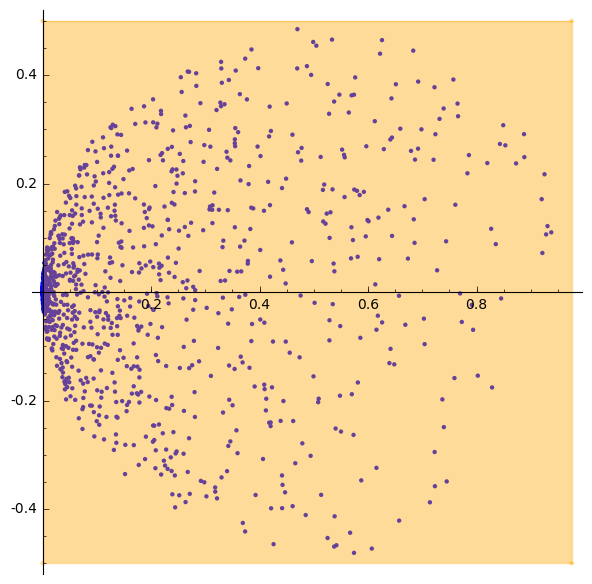

In [5]:
ineqBox = getBoundingBox(P,f)
inequalities = [[-ineqBox[0][0],1,0],[ineqBox[0][1],-1,0],[-ineqBox[1][0],0,1],[ineqBox[1][1],0,-1]]
fPBox = Polyhedron(ieqs = inequalities, base_ring=RDF)
fPBox.plot(alpha=0.4,color='orange') + points(fevaluationPoints) 